### topic modeling

In [3]:
import re
import time
import numpy as np
import pandas as pd
from pprint import pprint
 
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
 
# spacy for lemmatization
import spacy
 
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

LDA 접근방식  
- 각 도큐먼트를 특정 비율의 토픽의 집합으로 가정  
- 각 토픽은 각 키워드의 일정 비율로 구성  
- 토픽은 일반적으로 표현되는 지배적인 키워드의 모음  

In [4]:
enws = pd.read_csv('data/economy_news_전처리.csv',usecols=['id','dat','title','text','press'],parse_dates=True)

In [5]:
enws.dat = pd.to_datetime(enws.dat)

In [6]:
enws['ymon'] = enws.dat.dt.strftime('%Y%m')

In [7]:
tridx = enws.loc[enws.dat<'2020-03-01'].id.max()

In [105]:
tridx

27460

In [8]:
# 불용어 준비
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

C:\ProgramData\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\ProgramData\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [9]:
%time
# 이메일 주소와 줄바꿈 문자 제거 
data = enws.text.tolist()
data = [re.sub('\\S*@\\S*\\s?','',sent) for sent in data] # 이메일제거
data = [re.sub('\\s+',' ',sent) for sent in data] # 줄바꿈문자 제거
data = [re.sub("\\'","",sent) for sent in data] # 작은따옴표 제거 
data = [re.sub("By\\s\\w+\\s\\w+\\s\\-\\s",'',sent) for sent in data] # writer 이름 제거 

Wall time: 0 ns


In [10]:
# 단어 토큰화와 텍스트 클린업 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True)) # deacc=True: 구두점 제거

data_words = list(sent_to_words(data))
print(data_words[:1])

[['after', 'decades', 'drowning', 'in', 'deflation', 'japan', 'property', 'market', 'is', 're', 'emerging', 'with', 'average', 'prices', 'for', 'new', 'condos', 'in', 'tokyo', 'hitting', 'levels', 'not', 'seen', 'since', 'according', 'to', 'the', 'real', 'estate', 'economic', 'institute', 'said', 'this', 'week', 'if', 'the', 'trend', 'continues', 'and', 'broadens', 'it', 'could', 'mark', 'turnaround', 'in', 'the', 'long', 'dormant', 'financial', 'fortunes', 'of', 'the', 'worlds', 'third', 'largest', 'economy', 'such', 'turnaround', 'is', 'long', 'overdue', 'japan', 'real', 'estate', 'prices', 'have', 'been', 'falling', 'for', 'nearly', 'years', 'from', 'to', 'falling', 'real', 'estate', 'prices', 'swallowed', 'an', 'estimated', 'trillion', 'of', 'the', 'nation', 'wealth', 'according', 'to', 'the', 'nomura', 'research', 'institute', 'now', 'there', 'evidence', 'from', 'various', 'sectors', 'that', 'the', 'real', 'estate', 'market', 'is', 'rising', 'mt', 'fuji', 'nightfall', 'photo', 'by

In [11]:
train = data_words[:27460]
test = data_words[27460:]

In [14]:
s = time.time()
# bigram과 trigram모델 만들기 
bigram_train = gensim.models.Phrases(train,min_count=5,threshold=100) # threshold가 크면 단어구가 적게만들어짐
trigram_train = gensim.models.Phrases(bigram_train[train], threshold=100)
time.time()-s

192.1622931957245

In [15]:
s = time.time()
bigram_mod = gensim.models.phrases.Phraser(bigram_train)
trigram_mod = gensim.models.phrases.Phraser(trigram_train)
e = time.time()-s
time.strftime('%M:%S',time.gmtime(e))

'01:19'

In [16]:
# 불용단어 제거하고 bigram만들고 표준형 변환 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """https://spac.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
# stopwords 제거 
train_nostops = remove_stopwords(train)
train_bigrams = make_bigrams(train_nostops)

In [18]:
nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])

In [19]:
train_lemmatized = lemmatization(train_bigrams, allowed_postags=['NOUN','ADJ','VERB','ADV'])

In [20]:
# LDA 주요 입력값: 사전(id2word), 코퍼스 만들기
id2word = corpora.Dictionary(train_lemmatized)
texts = train_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])
# gensim은 문서안의 각 단어에 대해 유니크한 id를 만든다.
# 생성된 코퍼스는 (word_id, word_frequency)의 매핑임 
# (0,7) : 단어id 0이 7번 발생함을 의미 

[[(0, 7), (1, 2), (2, 1), (3, 2), (4, 1), (5, 5), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 3), (17, 3), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 3), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 5), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 6), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 2), (77, 1), (78, 3), (79, 4), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 4), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 2), (96, 11), (97, 4), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 13), (104, 3), (105, 1), (106, 3), (107, 1), (108, 1), (109, 1), (110, 

### Mallet: Coherence 점수로 적정 Topic 갯수 구하기 

In [ ]:
gc.collect()

**최적 Mallet Topic Model**

In [21]:
# 최적의 lda 토픽수 찾기 
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    
    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    
    Returns:
    --------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(str(num_topics),'done')
    return model_list, coherence_values

In [23]:
mallet_path = 'd:/pkg/mallet-2.0.8/bin/mallet'

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=train_lemmatized, start=2, limit=40, step=6)

2 done
8 done
14 done
20 done
26 done
32 done
38 done


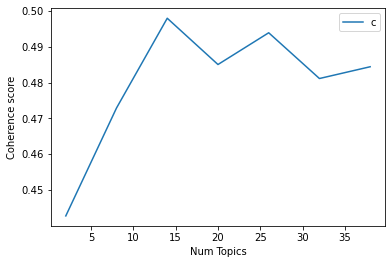

In [25]:
# show graph
limit = 40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [26]:
for m, cv in zip(x, coherence_values):
    print('Num Topics = ',m,' has Coherence Value of', round(cv,4))

Num Topics =  2  has Coherence Value of 0.4428
Num Topics =  8  has Coherence Value of 0.4729
Num Topics =  14  has Coherence Value of 0.498
Num Topics =  20  has Coherence Value of 0.4851
Num Topics =  26  has Coherence Value of 0.4939
Num Topics =  32  has Coherence Value of 0.4811
Num Topics =  38  has Coherence Value of 0.4844


In [27]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.094*"bank" + 0.058*"financial" + 0.024*"risk" + 0.019*"loan" + '
  '0.019*"capital" + 0.016*"crisis" + 0.012*"credit" + 0.012*"banking" + '
  '0.011*"firm" + 0.011*"sector"'),
 (1,
  '0.035*"rule" + 0.028*"country" + 0.020*"finance" + 0.015*"reform" + '
  '0.015*"german" + 0.015*"european" + 0.014*"minister" + 0.013*"make" + '
  '0.012*"euro" + 0.010*"member"'),
 (2,
  '0.017*"year" + 0.015*"company" + 0.011*"industry" + 0.010*"home" + '
  '0.009*"business" + 0.009*"accord" + 0.009*"sale" + 0.008*"price" + '
  '0.008*"project" + 0.008*"country"'),
 (3,
  '0.043*"market" + 0.031*"week" + 0.030*"report" + 0.020*"month" + '
  '0.020*"datum" + 0.019*"high" + 0.019*"oil" + 0.019*"price" + 0.015*"rise" + '
  '0.015*"stock"'),
 (4,
  '0.086*"percent" + 0.066*"growth" + 0.057*"year" + 0.041*"economy" + '
  '0.025*"expect" + 0.022*"month" + 0.022*"quarter" + 0.020*"economic" + '
  '0.019*"rise" + 0.018*"forecast"'),
 (5,
  '0.059*"market" + 0.039*"bond" + 0.037*"year" + 0.031*"investo

### mallet model 저장하기

In [44]:
import pickle
pickle.dump(optimal_model, open('model/ldamallet.pkl','wb'))

### mallet model 불러오기

In [46]:
model1 = pickle.load(open('model/ldamallet.pkl','rb'))

### topic 확률 생성

In [51]:
# stopwords 제거 
test_nostops = remove_stopwords(test)
test_bigrams = make_bigrams(test_nostops)

In [18]:
nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])

In [52]:
test_lemmatized = lemmatization(test_bigrams, allowed_postags=['NOUN','ADJ','VERB','ADV'])

In [97]:
# LDA 주요 입력값: 사전(id2word), 코퍼스 만들기
# test_id2word = corpora.Dictionary(test_lemmatized)
test_texts = test_lemmatized
test_corpus = [id2word.doc2bow(text) for text in test_texts]

In [98]:
train_topic_prob = model1[corpus]
test_topic_prob = model1[test_corpus]

In [99]:
tr_topic_prob = pd.DataFrame([{k:v for k,v in t} for t in train_topic_prob])
te_topic_prob = pd.DataFrame([{k:v for k,v in t} for t in test_topic_prob])

In [100]:
tr_topic_prob.shape

(27460, 14)

In [101]:
te_topic_prob.shape

(8083, 14)

In [102]:
tr_topic_prob.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.046889,0.017515,0.190355,0.109895,0.223134,0.056681,0.049869,0.019644,0.058809,0.103083,0.017941,0.028158,0.052849,0.025178
1,0.326864,0.043484,0.091103,0.027611,0.062158,0.029478,0.055622,0.037415,0.063559,0.019675,0.028545,0.102774,0.065893,0.045818
2,0.058407,0.071352,0.042225,0.113423,0.070273,0.046540,0.085375,0.040068,0.048698,0.241794,0.045462,0.043304,0.049777,0.043304
3,0.056878,0.022310,0.134656,0.076014,0.028483,0.043915,0.026014,0.035891,0.093298,0.031570,0.041446,0.352557,0.030335,0.026631
4,0.041333,0.061135,0.160695,0.090288,0.080387,0.089738,0.042433,0.075986,0.131542,0.057284,0.033082,0.038032,0.075436,0.022631


In [118]:
tridx

27460

In [130]:
# mallet 이용
# 기사별 토픽확률 생성 
# 2020.2월까지 train
# 2020.3월부터 test
topic_prob = pd.concat([tr_topic_prob,te_topic_prob],axis=0).reset_index(drop=True)
topic_prob = pd.concat([enws[['id','dat']].reset_index(drop=True),topic_prob],axis=1)
topic_prob.loc[:27460,'tr_te'] = 1
topic_prob.loc[27460:,'tr_te'] = 2
topic_prob.tr_te = topic_prob.tr_te.astype(int)
topic_prob.columns = ['id','dat']+['topic'+str(i+1) for i in range(14)]+['tr_te']

In [131]:
topic_prob.to_csv('data/topic_prob.csv',index=False)

In [132]:
topic_prob.head()

,id,dat,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,tr_te
0,1,2014-01-22,0.046889,0.017515,0.190355,0.109895,0.223134,0.056681,0.049869,0.019644,0.058809,0.103083,0.017941,0.028158,0.052849,0.025178,1
1,2,2014-01-22,0.326864,0.043484,0.091103,0.027611,0.062158,0.029478,0.055622,0.037415,0.063559,0.019675,0.028545,0.102774,0.065893,0.045818,1
2,3,2014-01-23,0.058407,0.071352,0.042225,0.113423,0.070273,0.046540,0.085375,0.040068,0.048698,0.241794,0.045462,0.043304,0.049777,0.043304,1
3,4,2014-01-23,0.056878,0.022310,0.134656,0.076014,0.028483,0.043915,0.026014,0.035891,0.093298,0.031570,0.041446,0.352557,0.030335,0.026631,1
4,5,2014-01-23,0.041333,0.061135,0.160695,0.090288,0.080387,0.089738,0.042433,0.075986,0.131542,0.057284,0.033082,0.038032,0.075436,0.022631,1


## (이하) 기타 코드

**1개 Mallet Topic Model 만들기**

In [225]:
# LDA Mallet 모델 만들기 
mallet_path = 'd:/pkg/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 20, id2word = id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

In [228]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=train_lemmatized, dictionary = id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ',coherence_ldamallet)


Coherence Score:  0.49830146488360905


### **기타 코드**

In [111]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accord', 7),
  ('ahead', 2),
  ('also', 1),
  ('area', 2),
  ('available', 1),
  ('average', 5),
  ('back', 1),
  ('bank', 1),
  ('borrower', 1),
  ('broaden', 1),
  ('building', 1),
  ('bumpy', 1),
  ('business', 1),
  ('cheapen', 1),
  ('climb', 1),
  ('com', 1),
  ('compare', 3),
  ('condo', 3),
  ('construction', 1),
  ('continue', 2),
  ('cost', 1),
  ('could', 2),
  ('datum', 1),
  ('decade', 1),
  ('deflation', 1),
  ('dormant', 1),
  ('drown', 1),
  ('earlier', 3),
  ('early', 1),
  ('economic', 1),
  ('economy', 2),
  ('effort', 1),
  ('emerge', 1),
  ('encourage', 1),
  ('estimate', 1),
  ('even', 1),
  ('evidence', 1),
  ('exist', 1),
  ('expectation', 1),
  ('fall', 3),
  ('fifthly', 1),
  ('financial', 1),
  ('first', 1),
  ('firstly', 1),
  ('fiscal', 1),
  ('fix', 1),
  ('fortune', 1),
  ('fourthly', 1),
  ('global', 1),
  ('goal', 1),
  ('government', 1),
  ('grow', 5),
  ('guide', 1),
  ('high', 1),
  ('hit', 1),
  ('home', 2),
  ('impact', 1),
  ('include', 1),
  

In [179]:
# 토픽 모델 만들기 
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [180]:
# lda 모델의 토픽보기 
# 토픽별 10개 키워드 
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.044*"say" + 0.014*"year" + 0.014*"go" + 0.013*"make" + 0.012*"people" + '
  '0.012*"would" + 0.011*"time" + 0.011*"take" + 0.010*"could" + 0.010*"get"'),
 (1,
  '0.076*"home" + 0.057*"price" + 0.055*"housing" + 0.043*"property" + '
  '0.039*"sale" + 0.035*"city" + 0.034*"mortgage" + 0.030*"household" + '
  '0.025*"cool" + 0.021*"buyer"'),
 (2,
  '0.234*"trade" + 0.083*"tariff" + 0.073*"chinese" + 0.045*"good" + '
  '0.030*"import" + 0.028*"export" + 0.028*"war" + 0.024*"talk" + '
  '0.023*"global" + 0.021*"deal"'),
 (3,
  '0.044*"digital" + 0.040*"insurance" + 0.037*"technology" + 0.033*"consumer" '
  '+ 0.032*"customer" + 0.028*"tech" + 0.026*"service" + 0.024*"network" + '
  '0.022*"payment" + 0.022*"use"'),
 (4,
  '0.145*"food" + 0.082*"italian" + 0.055*"season" + 0.053*"item" + '
  '0.044*"hotel" + 0.041*"black" + 0.038*"restaurant" + 0.035*"climate_change" '
  '+ 0.029*"collection" + 0.028*"chip"'),
 (5,
  '0.079*"company" + 0.031*"business" + 0.025*"firm" + 0.022*"indus

In [181]:
# 모델 난이도와 일관성 점수 계산 
print('\nPerplexity: ',lda_model.log_perplexity(corpus))


Perplexity:  -10.007470477905306


In [182]:
coherence_model_lda = CoherenceModel(model = lda_model, texts = train_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ',coherence_lda)


Coherence Score:  0.45391983449464923


In [190]:
tpr = [lda_model.get_document_topics(c) for c in corpus[:10]]
tpr

[[(0, 0.039064944),
  (1, 0.23853052),
  (7, 0.22616611),
  (8, 0.039323464),
  (9, 0.25449947),
  (11, 0.03941763),
  (17, 0.05663374),
  (18, 0.032787155),
  (19, 0.060852256)],
 [(0, 0.1376976),
  (1, 0.025801694),
  (5, 0.07948344),
  (6, 0.10837357),
  (9, 0.046786692),
  (10, 0.029014887),
  (13, 0.30924252),
  (16, 0.038003113),
  (17, 0.06468784),
  (18, 0.11934305),
  (19, 0.028400019)],
 [(0, 0.041109044),
  (5, 0.011147422),
  (7, 0.1579221),
  (9, 0.110561796),
  (17, 0.05226727),
  (18, 0.22173339),
  (19, 0.37446195)],
 [(0, 0.18398969),
  (1, 0.036000546),
  (2, 0.010855934),
  (3, 0.2113515),
  (5, 0.11228948),
  (6, 0.21998909),
  (7, 0.10612155),
  (8, 0.04930143),
  (18, 0.041730665)],
 [(0, 0.12479729),
  (2, 0.010040674),
  (5, 0.0828783),
  (7, 0.098115675),
  (8, 0.057910703),
  (9, 0.12229714),
  (10, 0.04566448),
  (15, 0.01264076),
  (17, 0.3470738),
  (18, 0.067172185),
  (19, 0.016773101)],
 [(0, 0.17908257),
  (2, 0.03192796),
  (5, 0.06300078),
  (6, 0.020

In [205]:
tpd = pd.concat([pd.DataFrame(t).assign(idx=i) for i,t in enumerate(tpr)])
tpd = tpd.pivot(index='idx',columns=0,values=1).fillna(0)

In [206]:
tpd.head()

,0,1,2,3,5,6,7,8,9,10,11,12,13,15,16,17,18,19
idx,,,,,,,,,,,,,,,,,,
0,0.039065,0.238531,0.000000,0.000000,0.000000,0.000000,0.226166,0.039323,0.254499,0.000000,0.039418,0.0,0.000000,0.000000,0.000000,0.056634,0.032787,0.060852
1,0.137698,0.025802,0.000000,0.000000,0.079483,0.108374,0.000000,0.000000,0.046787,0.029015,0.000000,0.0,0.309243,0.000000,0.038003,0.064688,0.119343,0.028400
2,0.041109,0.000000,0.000000,0.000000,0.011147,0.000000,0.157922,0.000000,0.110562,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.052267,0.221733,0.374462
3,0.183990,0.036001,0.010856,0.211351,0.112289,0.219989,0.106122,0.049301,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.041731,0.000000
4,0.124797,0.000000,0.010041,0.000000,0.082878,0.000000,0.098116,0.057911,0.122297,0.045664,0.000000,0.0,0.000000,0.012641,0.000000,0.347074,0.067172,0.016773


In [211]:
tpd['sum'] = tpd.sum(axis=1)

In [212]:
tpd.head()

,0,1,2,3,5,6,7,8,9,10,11,12,13,15,16,17,18,19,sum
idx,,,,,,,,,,,,,,,,,,,
0,0.039065,0.238531,0.000000,0.000000,0.000000,0.000000,0.226166,0.039323,0.254499,0.000000,0.039418,0.0,0.000000,0.000000,0.000000,0.056634,0.032787,0.060852,0.987275
1,0.137698,0.025802,0.000000,0.000000,0.079483,0.108374,0.000000,0.000000,0.046787,0.029015,0.000000,0.0,0.309243,0.000000,0.038003,0.064688,0.119343,0.028400,0.986834
2,0.041109,0.000000,0.000000,0.000000,0.011147,0.000000,0.157922,0.000000,0.110562,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.052267,0.221733,0.374462,0.969203
3,0.183990,0.036001,0.010856,0.211351,0.112289,0.219989,0.106122,0.049301,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.041731,0.000000,0.971630
4,0.124797,0.000000,0.010041,0.000000,0.082878,0.000000,0.098116,0.057911,0.122297,0.045664,0.000000,0.0,0.000000,0.012641,0.000000,0.347074,0.067172,0.016773,0.985364


In [ ]:
# 토픽-키워드 시각화
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

### Coherence 점수로 적정 Topic 갯수 구하기 

In [215]:
np.arange(3,20)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [ ]:
coh_score = []
for i in np.arange(3,21):
    lda = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word=id2word,
                                           num_topics=i,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coh_mod_ld = CoherenceModel(model = lda, texts = train_lemmatized, dictionary=id2word, coherence='c_v')
    coh_score.append(coh_mod_ld.get_coherence())
    print('num_topics:',str(i),' done')
coh = pd.DataFrame({'num_topics': np.arange(3,21), 'coherence':coh_score})

In [ ]:
coh.style.background_gradient()

In [111]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accord', 7),
  ('ahead', 2),
  ('also', 1),
  ('area', 2),
  ('available', 1),
  ('average', 5),
  ('back', 1),
  ('bank', 1),
  ('borrower', 1),
  ('broaden', 1),
  ('building', 1),
  ('bumpy', 1),
  ('business', 1),
  ('cheapen', 1),
  ('climb', 1),
  ('com', 1),
  ('compare', 3),
  ('condo', 3),
  ('construction', 1),
  ('continue', 2),
  ('cost', 1),
  ('could', 2),
  ('datum', 1),
  ('decade', 1),
  ('deflation', 1),
  ('dormant', 1),
  ('drown', 1),
  ('earlier', 3),
  ('early', 1),
  ('economic', 1),
  ('economy', 2),
  ('effort', 1),
  ('emerge', 1),
  ('encourage', 1),
  ('estimate', 1),
  ('even', 1),
  ('evidence', 1),
  ('exist', 1),
  ('expectation', 1),
  ('fall', 3),
  ('fifthly', 1),
  ('financial', 1),
  ('first', 1),
  ('firstly', 1),
  ('fiscal', 1),
  ('fix', 1),
  ('fortune', 1),
  ('fourthly', 1),
  ('global', 1),
  ('goal', 1),
  ('government', 1),
  ('grow', 5),
  ('guide', 1),
  ('high', 1),
  ('hit', 1),
  ('home', 2),
  ('impact', 1),
  ('include', 1),
  

In [179]:
# 토픽 모델 만들기 
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [180]:
# lda 모델의 토픽보기 
# 토픽별 10개 키워드 
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.044*"say" + 0.014*"year" + 0.014*"go" + 0.013*"make" + 0.012*"people" + '
  '0.012*"would" + 0.011*"time" + 0.011*"take" + 0.010*"could" + 0.010*"get"'),
 (1,
  '0.076*"home" + 0.057*"price" + 0.055*"housing" + 0.043*"property" + '
  '0.039*"sale" + 0.035*"city" + 0.034*"mortgage" + 0.030*"household" + '
  '0.025*"cool" + 0.021*"buyer"'),
 (2,
  '0.234*"trade" + 0.083*"tariff" + 0.073*"chinese" + 0.045*"good" + '
  '0.030*"import" + 0.028*"export" + 0.028*"war" + 0.024*"talk" + '
  '0.023*"global" + 0.021*"deal"'),
 (3,
  '0.044*"digital" + 0.040*"insurance" + 0.037*"technology" + 0.033*"consumer" '
  '+ 0.032*"customer" + 0.028*"tech" + 0.026*"service" + 0.024*"network" + '
  '0.022*"payment" + 0.022*"use"'),
 (4,
  '0.145*"food" + 0.082*"italian" + 0.055*"season" + 0.053*"item" + '
  '0.044*"hotel" + 0.041*"black" + 0.038*"restaurant" + 0.035*"climate_change" '
  '+ 0.029*"collection" + 0.028*"chip"'),
 (5,
  '0.079*"company" + 0.031*"business" + 0.025*"firm" + 0.022*"indus

In [181]:
# 모델 난이도와 일관성 점수 계산 
print('\nPerplexity: ',lda_model.log_perplexity(corpus))


Perplexity:  -10.007470477905306


In [182]:
coherence_model_lda = CoherenceModel(model = lda_model, texts = train_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ',coherence_lda)


Coherence Score:  0.45391983449464923


In [190]:
tpr = [lda_model.get_document_topics(c) for c in corpus[:10]]
tpr

[[(0, 0.039064944),
  (1, 0.23853052),
  (7, 0.22616611),
  (8, 0.039323464),
  (9, 0.25449947),
  (11, 0.03941763),
  (17, 0.05663374),
  (18, 0.032787155),
  (19, 0.060852256)],
 [(0, 0.1376976),
  (1, 0.025801694),
  (5, 0.07948344),
  (6, 0.10837357),
  (9, 0.046786692),
  (10, 0.029014887),
  (13, 0.30924252),
  (16, 0.038003113),
  (17, 0.06468784),
  (18, 0.11934305),
  (19, 0.028400019)],
 [(0, 0.041109044),
  (5, 0.011147422),
  (7, 0.1579221),
  (9, 0.110561796),
  (17, 0.05226727),
  (18, 0.22173339),
  (19, 0.37446195)],
 [(0, 0.18398969),
  (1, 0.036000546),
  (2, 0.010855934),
  (3, 0.2113515),
  (5, 0.11228948),
  (6, 0.21998909),
  (7, 0.10612155),
  (8, 0.04930143),
  (18, 0.041730665)],
 [(0, 0.12479729),
  (2, 0.010040674),
  (5, 0.0828783),
  (7, 0.098115675),
  (8, 0.057910703),
  (9, 0.12229714),
  (10, 0.04566448),
  (15, 0.01264076),
  (17, 0.3470738),
  (18, 0.067172185),
  (19, 0.016773101)],
 [(0, 0.17908257),
  (2, 0.03192796),
  (5, 0.06300078),
  (6, 0.020

In [205]:
tpd = pd.concat([pd.DataFrame(t).assign(idx=i) for i,t in enumerate(tpr)])
tpd = tpd.pivot(index='idx',columns=0,values=1).fillna(0)

In [206]:
tpd.head()

,0,1,2,3,5,6,7,8,9,10,11,12,13,15,16,17,18,19
idx,,,,,,,,,,,,,,,,,,
0,0.039065,0.238531,0.000000,0.000000,0.000000,0.000000,0.226166,0.039323,0.254499,0.000000,0.039418,0.0,0.000000,0.000000,0.000000,0.056634,0.032787,0.060852
1,0.137698,0.025802,0.000000,0.000000,0.079483,0.108374,0.000000,0.000000,0.046787,0.029015,0.000000,0.0,0.309243,0.000000,0.038003,0.064688,0.119343,0.028400
2,0.041109,0.000000,0.000000,0.000000,0.011147,0.000000,0.157922,0.000000,0.110562,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.052267,0.221733,0.374462
3,0.183990,0.036001,0.010856,0.211351,0.112289,0.219989,0.106122,0.049301,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.041731,0.000000
4,0.124797,0.000000,0.010041,0.000000,0.082878,0.000000,0.098116,0.057911,0.122297,0.045664,0.000000,0.0,0.000000,0.012641,0.000000,0.347074,0.067172,0.016773


In [211]:
tpd['sum'] = tpd.sum(axis=1)

In [212]:
tpd.head()

,0,1,2,3,5,6,7,8,9,10,11,12,13,15,16,17,18,19,sum
idx,,,,,,,,,,,,,,,,,,,
0,0.039065,0.238531,0.000000,0.000000,0.000000,0.000000,0.226166,0.039323,0.254499,0.000000,0.039418,0.0,0.000000,0.000000,0.000000,0.056634,0.032787,0.060852,0.987275
1,0.137698,0.025802,0.000000,0.000000,0.079483,0.108374,0.000000,0.000000,0.046787,0.029015,0.000000,0.0,0.309243,0.000000,0.038003,0.064688,0.119343,0.028400,0.986834
2,0.041109,0.000000,0.000000,0.000000,0.011147,0.000000,0.157922,0.000000,0.110562,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.052267,0.221733,0.374462,0.969203
3,0.183990,0.036001,0.010856,0.211351,0.112289,0.219989,0.106122,0.049301,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.041731,0.000000,0.971630
4,0.124797,0.000000,0.010041,0.000000,0.082878,0.000000,0.098116,0.057911,0.122297,0.045664,0.000000,0.0,0.000000,0.012641,0.000000,0.347074,0.067172,0.016773,0.985364


In [ ]:
# 토픽-키워드 시각화
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

### Coherence 점수로 적정 Topic 갯수 구하기 

In [215]:
np.arange(3,20)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [ ]:
coh_score = []
for i in np.arange(3,21):
    lda = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word=id2word,
                                           num_topics=i,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coh_mod_ld = CoherenceModel(model = lda, texts = train_lemmatized, dictionary=id2word, coherence='c_v')
    coh_score.append(coh_mod_ld.get_coherence())
    print('num_topics:',str(i),' done')
coh = pd.DataFrame({'num_topics': np.arange(3,21), 'coherence':coh_score})

In [ ]:
coh.style.background_gradient()